# Introduction

This notebook is meant to process a data set through the full Imager pipeline for TSO data (calwebb_tso1, calwebb_tso-image2 and calwebb_tso3). The steps are as follow:

1) Read in list of data (uncalibrated) files.

2) Process through calwebb_detctor1 using parameters set in calwebb_tso1.cfg.

3) Process ramp fit (slope) files through calwebb_image2 using parameters in calwebb_tso-image2.cfg.

4) Create an assocation tale for the calibrated files.

5) Run the calibrated files through calwebb_tso3 using the association table.

These steps are set up with an example simulated MIRI dataset.

The pipeline documentation can be found here: https://jwst-pipeline.readthedocs.io/en/latest/

The pipeline code is available on GitHub: https://github.com/spacetelescope/jwst

This notebook is simply meant to demonstrate how to run data through each of the pipeline stages using a jupyter notebook, and allow the user to edit and change parameters for different tests through the pipeline.


### Set up import statements

In [1]:
from astropy.io import fits, ascii
from jwst import associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
from jwst.datamodels import RampModel
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Tso3Pipeline
import matplotlib.pyplot as plt
import numpy as np
import os
import pysiaf
from photutils import CircularAperture, DAOStarFinder, CircularAnnulus, aperture_photometry, centroids

### Read in list of files and update headers to have needed keywords for TSO mode

In [15]:
def checkheaders(model):
    
    # check that header has keyword TSOVISIT set to true (all TSO data should have this set)
    
    if model.meta.visit.tsovisit != True:
        model.meta.visit.tsovisit = True
        print('Setting TSOVISIT keyword')
        
    # check that CRPIX1 and CRPIX2 are set to the center of the siaf aperture for the array being used.
    # Read in array being used
    array = model.meta.subarray.name
    print(array)
    if array == 'FULL':
        siaf = pysiaf.Siaf('MIRI') 
        full = siaf['MIRIM_FULL']
        model.meta.wcsinfo.crpix1 = full.XSciRef
        model.meta.wcsinfo.crpix2 = full.YSciRef
    if array == 'SUB64':
        # subarray siaf values are not quite right in MIRISim. Need to centroid to find x and y
        # start with siaf values
        siaf = pysiaf.Siaf('MIRI')
        sub = siaf['MIRIM_SUB64']
        x_initial = sub.XSciRef - 8 # known 8 pixel shift in subarray source position
        y_initial = sub.YSciRef
        
        print(x_initial, y_initial)
        
        # Take initial estimate and centroid to find source
        center = centroids.centroid_sources(model.data[0,0,:,:], x_initial, y_initial, box_size=11)
        xcentroid = center[0][0]
        ycentroid = center[1][0]
        
        print(center[0][0], center[1][0])   
        model.meta.wcsinfo.crpix1 = xcentroid
        model.meta.wcsinfo.crpix2 = ycentroid



### Set up parameters for individual steps and run calwebb_detector1

In [16]:
# Run the calwebb_detector1 pipeline

# set up pipeline parameters and file names
# Input file names
datadir = '/ifs/jwst/wit/miri/pipelinetests/cracraft/build7_5/'
filelist = 'tsoim_wasp_sub64_file.txt'  # List of input uncalibrated files

# output information
slopefiles='tso_sub64_rateintsfiles.txt'  # list of slope images output from detector1
tag='_b75_tso'  # string tag to distinguish different tests in output file name

# reference file overrides
satfile = '/grp/jwst/wit/odl/miri/miri_sat_55k.fits'
readnoisefile = '/grp/jwst/wit/odl/miri/jwst_mirisim_readnoise.fits' # use when running MIRISim data
    
# step parameters
rej_thresh=10.0  # rejection threshold for jump step

# read in list of input files
imlist1 = np.loadtxt(datadir+filelist,dtype=bytes, ndmin=1).astype(str)  # avoid the 'b at the start of a line

print('There are ', imlist1.size, ' images.')
    
# set up pipeline parameters for input
pipe1 = Detector1Pipeline()
pipe1.jump.rejection_threshold = rej_thresh
pipe1.saturation.override_saturation = satfile
pipe1.jump.override_readnoise = readnoisefile
pipe1.ramp_fit.override_readnoise = readnoisefile

# skip steps to make it like 'tso1 config file'
pipe1.ipc.skip = True
pipe1.firstframe.skip = True
pipe1.lastframe.skip = True
    
# open output file for ramp fit file names
f = open(datadir+slopefiles,'w')
    
# loop over list of files
for file in imlist1:
       
    # check that header has needed keywords set
    model = RampModel(datadir+file)
        
    checkheaders(model)

    nints = model.meta.exposure.nints
    print('CRPIX1 = ',model.meta.wcsinfo.crpix1)
    print('CRPIX2 = ',model.meta.wcsinfo.crpix2)
    
    # set up output file name
    base, remainder = file.split('.')
    #print(base)
    outname = base+tag
    #print(outname)
        
    pipe1.jump.output_file = datadir+outname+'.fits'    
    pipe1.ramp_fit.output_file = datadir+outname+'.fits'
    pipe1.output_file = datadir+outname+'.fits'
    pipe1.output_dir = datadir
            
    # Run pipeline on each file
    pipe1.run(model) 
        
    # write out name of output files to text file for later use
    f.write(outname+'_rateints.fits'+'\n')
f.close()
print('Detector 1 steps completed on all files.')

2020-07-02 14:56:05,589 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2020-07-02 14:56:05,591 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2020-07-02 14:56:05,593 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2020-07-02 14:56:05,595 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2020-07-02 14:56:05,598 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2020-07-02 14:56:05,600 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2020-07-02 14:56:05,602 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2020-07-02 14:56:05,605 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2020-07-02 14:56:05,612 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2020-07-02 14:56:05,615 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2020-07-02 

There are  1  images.
Setting TSOVISIT keyword
SUB64


2020-07-02 14:56:06,808 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (<RampModel(10, 60, 64, 72) from wasp103_imtso_SUB64_60g10i1e_F770W.fits>,).


30.5 32.5
30.00053174704315 32.00013881556191
CRPIX1 =  30.00053174704315
CRPIX2 =  32.00013881556191


2020-07-02 14:56:06,880 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/ifs/jwst/wit/miri/pipelinetests/cracraft/build7_5/wasp103_imtso_SUB64_60g10i1e_F770W_b75_tso.fits', 'output_dir': '/ifs/jwst/wit/miri/pipelinetests/cracraft/build7_5/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': 

2020-07-02 14:56:08,615 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits
2020-07-02 14:56:09,978 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data
2020-07-02 14:56:10,013 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2020-07-02 14:56:10,212 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(10, 60, 64, 72) from wasp103_imtso_SUB64_60g10i1e_F770W.fits>,).
2020-07-02 14:56:10,222 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-02 14:56:10,293 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/jws

2020-07-02 14:56:39,753 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits
2020-07-02 14:56:40,611 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/jwst/wit/odl/miri/jwst_mirisim_readnoise.fits
2020-07-02 14:56:41,507 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data
2020-07-02 14:56:41,509 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data
2020-07-02 14:56:41,517 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2020-07-02 14:56:41,570 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2020-07-02 14:56:41,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 233 pixels with at least one CR
2020-07-02 14:56:41,611 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 2
2020-07-02 14:56:41,633 - stpipe.Detector1Pipeline.jump

Detector 1 steps completed on all files.


### Take output of detector1 pipeline, set any specific parameters and run through calwebb_image2

In [17]:
# Run Calwebb_image2

# set up output file for list of calibrated data
#datadir = '/ifs/jwst/wit/miri/pipelinetests/cracraft/build7_5/'
#slopefiles = '5star_rampfitfiles.txt'
calfiles = 'tso_sub64_b75_calibratedfiles.txt'    
    
# read in list of slope files (from level 1) for processsing through level 2
imlist2 = np.loadtxt(datadir+slopefiles, dtype=bytes, ndmin=1).astype(str) # avoid the 'b at the start of a line
    
print('There are ', imlist2.size, ' images.')
    
f2 = open(datadir+calfiles,'w')
    
# create an object for the pipeline    
pipe2 = Image2Pipeline()

# skip steps to match calwebb_tso-image2.cfg file
pipe2.bkg_subtract.skip = True
pipe2.resample.skip = True

callist = []

# cycle through files
for rampfile in imlist2:
    # Set pipeline parameters
    pipe2.save_results = True
    pipe2.output_file = rampfile+'_cal.fits'
    pipe2.output_dir = datadir
    pipe2.resample.save_results = True
    pipe2.suffix = None
    #pipe2.resample.output_file = rampfile+'_i2d.fits'

    pipe2.run(datadir+rampfile)
    
    # create new output name to match output of pipeline
    base, remainder = rampfile.split('_rate')
    
    f2.write(base+'_calints.fits'+'\n')
    callist.append(base+'_calints.fits')
f2.close() 

print(callist)


2020-07-02 14:59:09,944 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2020-07-02 14:59:09,946 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2020-07-02 14:59:09,949 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2020-07-02 14:59:09,952 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2020-07-02 14:59:09,954 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2020-07-02 14:59:09,958 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2020-07-02 14:59:10,069 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/ifs/jwst/wit/miri/pipelinetests/cracraft/build7_5/wasp103_imtso_SUB64_60g10i1e_F770W_b75_tso_rateints.fits',).


There are  1  images.


2020-07-02 14:59:10,120 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/ifs/jwst/wit/miri/pipelinetests/cracraft/notebooks/wasp103_imtso_SUB64_60g10i1e_F770W_b75_tso_rateints.fits_cal.fits', 'output_dir': '/ifs/jwst/wit/miri/pipelinetests/cracraft/build7_5/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': T

2020-07-02 14:59:14,806 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2020-07-02 14:59:14,811 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2020-07-02 14:59:14,819 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2020-07-02 14:59:14,827 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2020-07-02 14:59:15,315 - stpipe.Image2Pipeline.flat_field - WARNING - /Users/cracraft/anaconda3/envs/jwst_b75/lib/python3.7/site-packages/jwst/flatfield/flat_field.py:185: RuntimeWarning: invalid value encountered in multiply
  science.var_flat = science.data**2 / flat_data_squared * flat_err**2

2020-07-02 14:59:15,348 - stpipe.Image2Pipeline.flat_

['wasp103_imtso_SUB64_60g10i1e_F770W_b75_tso_calints.fits']


### Create association table of data output from calwebb_image2.

The calwebb_tso3 pipeline takes in an association table of a set of images which should be combined. The association table can also be used to specify a background image to be subtracted or a source catalog to be used within the pipeline (sourcecat is not typically used with MIRI).

In [ ]:
# use asn_from_list to create association table
asn = asn_from_list.asn_from_list(callist, rule=DMS_Level3_Base, product_name=datadir+'wasp103_sub64_10int_tsoim.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open(datadir+'wasp103_sub64_10int_tsoim_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])


### Run calwebb_tso3 on the association table, setting any specific parameters.

In [18]:
# use association table created in previous step with calwebb_image3
#datadir = '/ifs/jwst/wit/miri/pipelinetests/20190906_131730_jumpsteptest_mirisim/'    
    
# set any specific parameters


#TSO3 pipeline contains steps outlier_detection, tso_photometry, extract_1d and white_light

pipe3=Tso3Pipeline()    
pipe3.outlier_detection.config_file = 'outlier_detection_tso.cfg'

pipe3.save_results = True
pipe3.output_dir = datadir
    
# run Image3
pipe3.run(datadir+'wasp103_sub64_10int_tsoim_asnfile.json')    

2020-07-02 15:03:09,316 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.
2020-07-02 15:03:09,321 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2020-07-02 15:03:09,324 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.
2020-07-02 15:03:09,327 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2020-07-02 15:03:09,330 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.
2020-07-02 15:03:09,449 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('/ifs/jwst/wit/miri/pipelinetests/cracraft/build7_5/wasp103_sub64_10int_tsoim_asnfile.json',).
2020-07-02 15:03:09,462 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/ifs/jwst/wit/miri/pipelinetests/cracraft/build7_5/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True

2020-07-02 15:03:18,941 - stpipe.Tso3Pipeline.outlier_detection - WARNING - /Users/cracraft/anaconda3/envs/jwst_b75/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()

2020-07-02 15:03:19,133 - stpipe.Tso3Pipeline.outlier_detection - INFO - Blotting (64, 72) <-- (63, 71)
2020-07-02 15:03:19,389 - stpipe.Tso3Pipeline.outlier_detection - WARNING - /Users/cracraft/anaconda3/envs/jwst_b75/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object

### Use section below to test photometry output

       MJD            aperture_sum   ...  net_aperture_sum net_aperture_sum_err
------------------ ----------------- ... ----------------- --------------------
 58484.70836338149 8095.827264284077 ... 7891.798904715401   126.81319311149285
 58484.70842347779  8098.05624423423 ... 7898.148919764893   126.73632877286363
 58484.70848357408 8097.193694992191 ... 7898.525434818349   126.90480160083803
 58484.70854367038 8102.398842825702 ... 7897.933394822627   127.08891112818348
58484.708603766674 8096.642715275331 ... 7895.266848154295   126.81127390966063
 58484.70866386297 8110.571641452449 ... 7906.679817962046   127.01473785538202
58484.708723959266 8122.526115670553 ... 7923.467895571003   127.17044293425496
 58484.70878405557 8098.674080192612 ...  7896.78863685101    126.8149474715044
58484.708844151864 8105.442816595763 ... 7902.635031620838   126.97864874171027
 58484.70890424816 8120.947820558791 ... 7919.791147000159    127.1131519794345
 net_aperture_sum
-----------------
7891

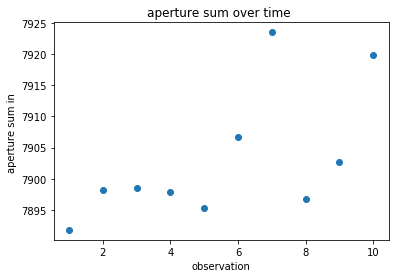

In [23]:
# read in ecsv photom file
from astropy import table
photfile = 'wasp103_sub64_10int_tsoim_phot.ecsv'

#mjd, ap_sum, _, ann_sum, _, ann_mean, _, ap_bckg, _, net_aper_sum, _ = np.loadtxt(os.path.join(datadir, photfile),
#                                                                                  dtype=str, unpack=True, 
#                                                                                  skiprows=31, comments='#')

#net_aper_sum_flt = net_aper_sum.astype(float)
#net_aper_sum_flt = list(map(float, net_aper_sum))
#print(net_aper_sum_flt)


#print(times)

data = table.Table.read(os.path.join(datadir, photfile), format='ascii', comment='#')
print(data)
#print(data['net_aperture_sum'])
times = np.arange(nints) + 1

# plot photometry in the net aperture sum after background subtraction as found in output file
plt.title('aperture sum over time ')
#plt.ylim(7500,8000) # help weed out sources that were erroneously 'hits' (bad pixels, cosmic rays, etc)
plt.xlabel('observation')
plt.ylabel('aperture sum in ')
plt.plot(times, data['net_aperture_sum'], marker='o',linestyle='') #ylim=(30000,40000))
#plt.savefig(dir+'testphot.png')
plt.show()



In [22]:
#Test code to read in model and find centroid of sub64
with RampModel(datadir+'wasp103_imtso_SUB64_60g10i1e_F770W.fits') as model:
    pass

array = model.meta.subarray.name
nints = model.meta.exposure.nints

print(nints)

if array == 'SUB64':
        # subarray siaf values are not quite right in MIRISim. Need to centroid to find x and y
        # start with siaf values
        siaf = pysiaf.Siaf('MIRI')
        sub = siaf['MIRIM_SUB64']
        x_initial = sub.XSciRef - 8
        y_initial = sub.YSciRef
        
        print(x_initial, y_initial)
        
        center = centroids.centroid_sources(model.data[0,3,:,:], x_initial, y_initial, box_size=11)
        
        print(center[0][0], center[1][0])   


10
30.5 32.5
29.998360026781214 31.997989152103756
